In [1]:
import pandas as pd
import numpy as np
import re
import pickle
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
import nltk.stem as stemmer
from nltk.stem.porter import *
from nltk.stem import WordNetLemmatizer
import pyLDAvis
import pyLDAvis.gensim
from sklearn.feature_extraction.text import TfidfVectorizer
import re
from nltk.stem import WordNetLemmatizer
from sklearn.decomposition import LatentDirichletAllocation
import numpy as np
import matplotlib.pyplot as plt
import collections
from gensim.models.phrases import Phrases, Phraser

C:\Users\Kenny Tang\AppData\Local\Programs\Python\Python310\lib\site-packages\gensim\matutils.py:22: DeprecationWarning: Please use `triu` from the `scipy.linalg` namespace, the `scipy.linalg.special_matrices` namespace is deprecated.
  from scipy.linalg.special_matrices import triu


In [2]:
from gensim.corpora.dictionary import Dictionary
from gensim.models import TfidfModel
from gensim.models.coherencemodel import CoherenceModel
from gensim.models import Nmf

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
top_artist = ['frank sinatra', 'elvis presley', 'dolly parton', 'lil wayne',
       'chris brown', 'guided by voices', 'prince', 'johnny cash', 'bob dylan',
       'george jones', 'neil young', 'bruce springsteen', 'snoop dogg',
       'eminem', '50 cent', 'roy orbison', 'ella fitzgerald', 'taylor swift',
       'waylon jennings', '2pac tupac shakur', 'bb king', 'bon jovi',
       'george strait', 'madonna', 'diana ross', 'bill monroe', 'beach boys',
       'barry manilow', 'alice cooper', 'nas', 'ray charles', 'beck']

In [5]:
df = pd.read_csv('clean_lyrics_df.csv')

In [6]:
df = df.drop('Unnamed: 0', axis= 1)
df = df[df.language == 'en'].dropna()
df.ALink = df.ALink.transform(lambda x: x.replace('/', '').replace('-', ' ').lower())
df.Lyric = df.Lyric.transform(lambda x: x.lower())
df = df[df.ALink.isin(top_artist)]

In [7]:
df

,ALink,SName,SLink,Lyric,language,features
0,50 cent,In da Club,/50-cent/in-da-club.html,"go, go, go, go\ngo, go, go shawty\nit's your b...",en,False
1,50 cent,21 Questions,/50-cent/21-questions.html,new york city!\nyou are now rapping...with 50 ...,en,False
2,50 cent,P.I.M.P.,/50-cent/p-i-m-p.html,i don't know what you heard about me\nbut a b*...,en,False
3,50 cent,Many Men (Wish Death),/50-cent/many-men-wish-death.html,man we gotta go get something to eat man\ni'm ...,en,False
4,50 cent,Candy Shop,/50-cent/candy-shop.html,yeah...\nuh huh\nso seductive\ni'll take you t...,en,False
...,...,...,...,...,...,...
14323,barry manilow,You Oughta Be Home With Me,/barry-manilow/you-oughta-be-home-with-me.html,"everybody's here, spinnin' the bottle\neverybo...",en,False
14324,barry manilow,You're Leaving Too Soon,/barry-manilow/youre-leaving-too-soon.html,you're leavin' too soon\nyou oughta try believ...,en,False
14325,barry manilow,You're Looking Hot Tonight,/barry-manilow/youre-looking-hot-tonight.html,you're looking hot tonight\nbarry manilow\nby:...,en,False
14326,barry manilow,You're There,/barry-manilow/youre-there.html,our friends all use the past tense when they s...,en,False


In [8]:
# Further text cleaning for topic modeling
def remove_dup_lines(lyrics):
    lyric_lines = lyrics.splitlines()
    unique_lines = []
    for line in lyric_lines:
        if line not in unique_lines:
            unique_lines.append(line.replace('.','').replace(',',''))
    clean_song = '\n'.join(unique_lines)
    return clean_song
df.Lyric = df.Lyric.apply(lambda x: remove_dup_lines(x))

### NMF model

In [9]:
class artist_wordcloud:
    
    def __init__(self,name):
        self.name = name
        self.SEED = 42
        self.df = None
        self.text = None
        self.dict = None
        self.corpus_tfidf = None
        self.model = None
        self.best_n_topics = None
        self.most_dom_topic = None
    
    def nmf_inputs(self):
        def preprocess_song(lyrics):
            # Define stopwords
            stop_words_list = stopwords.words('english')
            additional_stop_words = ["i'm", "i'll", "i've", "we've", "we're", "gonna", "wanna", "that's", "it's", "they're", "they've", "wasn't", "would've","could've", "they'll","i've"]
            stop_words_list += additional_stop_words
            preproc= WordNetLemmatizer().lemmatize

            cleaned_text = []
            text = re.sub("\[.+?\]", "", lyrics) #remove comments
            text = text.split('\n') # slit by lines and sentences
            text = [x for x in text if len(x) > 0] # remove empty lines
            for line in text:
                line_words = re.findall(r"\w+\*{0,5}'?\w*", line)
                for word in line_words:
                    cleaned_text.append(preproc(word))
            cleaned_text = [x for x in cleaned_text if (x not in stop_words_list) and (len(x)>2) ]

            return cleaned_text

        self.df = df[df.ALink == self.name].copy()
        lemma= WordNetLemmatizer()
        
        text = [preprocess_song(x) for x in self.df.Lyric]
        phraser_model = Phrases(text, min_count = 1, scoring = 'npmi', threshold= .8)
        phraser = phraser_model.freeze()
        self.text = [phraser[x] for x in text]
        
        art_dict = Dictionary(self.text)
        art_dict.filter_extremes(no_below = 3, no_above=.4, keep_n = None)
        self.dict = art_dict
        
        corpus = [self.dict.doc2bow(x) for x in self.text]
        tfidf = TfidfModel(corpus)
        self.corpus_tfidf = tfidf[corpus]
    
    def coherence_computation(self, min_topics, max_topics, coherence ='c_v'):
    
        ntopic_coher = {'n_topics':[], 'coherence': []}

        for num_topics in range(min_topics, max_topics+1):
            model = Nmf(self.corpus_tfidf, num_topics= num_topics, random_state = self.SEED, id2word = self.dict)
            coherencemodel = CoherenceModel(model=model, texts=self.text, dictionary=self.dict, topn = 10, coherence=coherence)
            ntopic_coher['n_topics'].append(num_topics)
            ntopic_coher['coherence'].append(coherencemodel.get_coherence())
        
        # save best number of topics to use
        self.best_n_topics = ntopic_coher['n_topics'][ntopic_coher['coherence'].index(max(ntopic_coher['coherence']))]
        
        plt = pd.DataFrame(ntopic_coher).set_index('n_topics').plot(
            ylabel = 'Coherence',
            xlabel= 'Number of Topics', 
            title = 'Average Coherence Score by # of Topics')
        return ntopic_coher
    
    def topic_model(self):
        
        self.model = Nmf(self.corpus_tfidf, num_topics= self.best_n_topics, random_state = self.SEED, id2word = self.dict)

        term_list = self.model.top_topics(corpus = self.corpus_tfidf, texts = self.text, topn=10, coherence = 'c_v')
        return term_list
    
    
    def get_dominant_topic(self):

        corpus_bow = [self.dict.doc2bow(x) for x in self.text]
        doc_top_list = list(self.model.get_document_topics(bow=corpus_bow))

        top_doc = []
        for d in doc_top_list:
            if len(d) == 1:
                top_doc.append(d[0][0])
            else:
                d.sort(key=lambda x: x[1], reverse = True)
                top_doc.append(d[0][0])

        counter = collections.Counter(top_doc)
        self.most_dom_topic = counter.most_common(1)[0][0]
        return self.most_dom_topic
    
    def show_best_topic(self):

        # return coherence scores and topic with words
        term_scores = self.model.show_topic(topicid = self.most_dom_topic, topn=30)
        wc_inputs = {word:freq for word, freq in term_scores}
        
        import warnings
        warnings.filterwarnings("ignore", category=DeprecationWarning) 
        import PIL
        from PIL import Image
        g_mask = np.array(Image.open("guitar.png"))
        g_mask = g_mask[100:,400:800]

        def transform_format(val):
            if val >= 100:
                return 255
            else:
                return 0

        g_trans = np.ndarray((g_mask.shape[0],g_mask.shape[1]), np.int32)
        for i in range(len(g_mask)):
            g_trans[i] = list(map(transform_format, g_mask[i]))

        wc = WordCloud(background_color='black',contour_width=3, contour_color='black', mask= g_trans).fit_words(wc_inputs)
        wc_clean = np.array(wc)
        wc_clean[g_trans ==255] = 255

        plt.figure(figsize = (40,18));
        plt.imshow(wc_clean);
        plt.axis("off");
        plt.show()

In [10]:
ts= artist_wordcloud('taylor swift')

In [11]:
ts.nmf_inputs()

{'n_topics': [2, 3, 4, 5, 6, 7, 8, 9, 10],
 'coherence': [0.3482488482243997,
  0.3128711428105582,
  0.3385559312739259,
  0.2857316017496495,
  0.2972013103644993,
  0.3432230663731194,
  0.2874603773644352,
  0.3305284756772897,
  0.28648614776897674]}

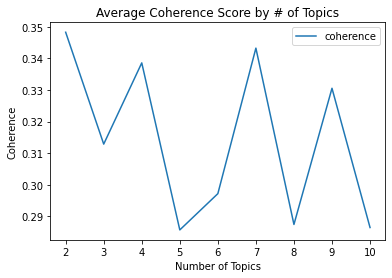

In [12]:
ts.coherence_computation(min_topics = 2, max_topics = 10)

In [13]:
ts.topic_model()

[([(0.008812296576158698, 'come'),
   (0.008680929243794058, 'baby'),
   (0.007114787363073433, 'ooh'),
   (0.005916377072002096, 'said'),
   (0.005442581178597395, 'way'),
   (0.0053748620836068725, 'would'),
   (0.005243648390183132, 'call'),
   (0.0048928036592044335, 'yeah'),
   (0.004787346307080624, 'want'),
   (0.004779051875241666, 'tell')],
  0.3596165508463799),
 ([(0.005559612326336994, 'let'),
   (0.005264572332296774, 'good'),
   (0.005254077859693079, 'remember'),
   (0.00515057133691771, 'well'),
   (0.004742090175386463, 'think'),
   (0.004708748582542875, 'beautiful'),
   (0.00454776390053661, 'day'),
   (0.004062572786822788, 'little'),
   (0.004039617711544711, 'stay'),
   (0.00395986898123702, 'song')],
  0.3368811456024195)]

In [14]:
ts.get_dominant_topic()

0

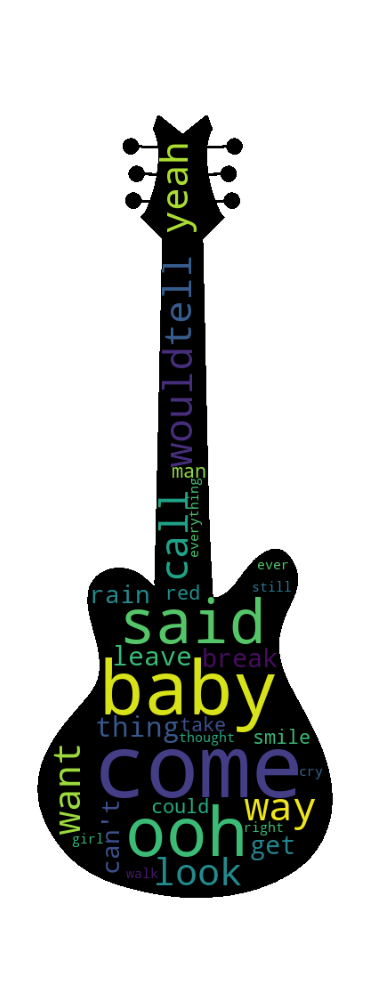

In [15]:
ts.show_best_topic()

In [16]:
#test

In [17]:
# ts_test = df[df.ALink == 'taylor swift']

In [18]:
# ts_test = df[df.ALink == 'eminem']

In [19]:
# def preprocess_song(lyrics):
#     # Define stopwords
#     stop_words_list = stopwords.words('english')
#     additional_stop_words = ["i'm", "i'll", "i've", "we've", "we're", "gonna", "wanna", "that's", "it's", "they're", "they've", "wasn't", "would've","could've", "they'll","i'd"]
#     stop_words_list += additional_stop_words
#     preproc= WordNetLemmatizer().lemmatize

#     cleaned_text = []
#     text = re.sub("\[.+?\]", "", lyrics) #remove comments
#     text = text.split('\n') # slit by lines and sentences
#     text = [x for x in text if len(x) > 0] # remove empty lines
#     for line in text:
#         line_words = re.findall(r"\w+\*{0,5}'?\w*", line)
#         for word in line_words:
#             cleaned_text.append(preproc(word))
#     cleaned_text = [x for x in cleaned_text if (x not in stop_words_list) and (len(x)>2) ]

#     return cleaned_text


# lemma= WordNetLemmatizer()
# text = [preprocess_song(x) for x in ts_test.Lyric]

# phraser_model = Phrases(text, min_count = 10, scoring = 'npmi', threshold= .8)
# phraser = phraser_model.freeze()
# text = [phraser[x] for x in text]

# ts_dict = Dictionary(text)
# ts_dict.filter_extremes(no_below = 3, no_above=.5, keep_n = None)

# corpus = [ts_dict.doc2bow(x) for x in text]
# tfidf = TfidfModel(corpus)
# corpus_tfidf = tfidf[corpus]